# Train Classifier For News Classification
> ## * Doc2Vec

In [1]:
import pickle
import html
import multiprocessing
from collections import namedtuple, OrderedDict
import re
import sys
import os
from glob import glob 
import warnings 

os.environ['KERAS_BACKEND']='tensorflow'

import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
import pandas as pd

from gensim.models import doc2vec, KeyedVectors
from gensim.models.doc2vec import TaggedDocument

from konlpy.utils import pprint

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report, roc_curve,  accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import scale, MinMaxScaler
from sklearn.manifold import TSNE

import keras.backend.tensorflow_backend as K
from keras.preprocessing import sequence
from keras_tqdm import TQDMCallback, TQDMNotebookCallback
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.layers import Input, Flatten, Dense, Embedding, embeddings, merge, Dropout, Activation,  LSTM, Bidirectional, SimpleRNN, GRU
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.pooling import MaxPooling1D, GlobalMaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.core import SpatialDropout1D
from keras.utils import np_utils
from tensorflow.python.client import device_lib
from keras.layers.merge import dot

import xgboost as xgb

import matplotlib.pyplot as plt

import seaborn as sns 

import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook
%matplotlib inline

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
print (device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2999517501222514560
]


In [3]:
import Basic_Module as bm

In [4]:
cores = int(multiprocessing.cpu_count() )
print (cores)

4


## Stopwords

In [5]:
stopwords = open('./data/stopwordsList.txt',encoding='utf-8').readlines()
stopwords = list(map(lambda x: x.strip(), stopwords))

## Documnet Labeling

In [6]:
TaggedDocument = namedtuple('TaggedDocument', 'words tags category')

> * words : 기사에서 나온 단어들 or keywords
> * tags : 문서 tag
> * classes : category
>> 기사분류가 daum보다 naver에서 더 세분화되어 있기 때문에 네이버의 category 분류를 이용하기로 함

## Category 

In [7]:
if os.path.isfile('./data/pre_data/news_tagged_data/pre_data_category_label_encoder_by_ct_for_doc2vec_news_classification.pickled'):
    le = pickle.load(open('./data/pre_data/news_tagged_data/pre_data_category_label_encoder_by_ct_for_doc2vec_news_classification.pickled','rb'))
else:
    le = LabelEncoder()
    le.fit(naverData['category'])
    pickle.dump(le, open('./data/pre_data/news_tagged_data/pre_data_category_label_encoder_by_ct_for_doc2vec_news_classification.pickled','wb'))
print (le.classes_)

['IT/과학' '경제' '사회' '생활/문화' '세계' '스포츠' '연예' '정치']


In [8]:
if sys.platform =='darwin':
    loadModelPath = './news_model/'
elif sys.platform =='win32':
    loadModelPath = 'd:/news_model/'
saveTrainPath = './data/pre_data/news_train_test_Data2/'
saveClassifierPath = './data/pre_data/news_classifier/'

## Twitter

### Load Model

In [9]:
model1 = doc2vec.Doc2Vec.load(loadModelPath+'doc2vec_size-500_epoch-20_window-10_negative-7_hs-0_dm-1_dm_concat-0_dm_mean-1_by-ct.model')
model2 = doc2vec.Doc2Vec.load(loadModelPath+'doc2vec_size-500_epoch-20_window-5_negative-7_hs-0_dm-1_dm_concat-1_dm_mean-0_by-ct.model')
model3 = doc2vec.Doc2Vec.load(loadModelPath+'doc2vec_size-500_epoch-20_window-None_negative-7_hs-0_dm-0_dm_concat-0_dm_mean-0_by-ct.model')

### Train dataset & test dataset

In [10]:
trainName = './data/pre_data/news_train_test_Data/pre_data_doc2vec_train_for_news_classification_by_ct.pickled'
testName = './data/pre_data/news_train_test_Data/pre_data_doc2vec_test_for_news_classification_by_ct.pickled'

In [11]:
train = pickle.load(open(trainName, 'rb'))
test = pickle.load(open(testName, 'rb'))

#### train dataset

In [12]:
taggerName = 'ct'
name1 = '-'.join(re.split('[\(\),\/]',str(model1)))+taggerName
if not os.path.isfile(saveTrainPath+'train_x_'+name1):
    train_x_by_m1 = bm.Get_Infer_Vector(train, model1)
    
    pickle.dump(train_x_by_m1,open(saveTrainPath+'train_x_'+name1,'wb'))
    del train_x_by_m1
    del name1
    
name2 = '-'.join(re.split('[\(\),\/]',str(model2)))+taggerName
if not os.path.isfile(saveTrainPath+'train_x_'+name2):
    train_x_by_m2 = bm.Get_Infer_Vector(train, model2)

    pickle.dump(train_x_by_m2,open(saveTrainPath+'train_x_'+name2,'wb'))
    del train_x_by_m2
    del name2

name3 = '-'.join(re.split('[\(\),\/]',str(model3)))+taggerName
if not os.path.isfile(saveTrainPath+'train_x_'+name3):
    train_x_by_m3 = bm.Get_Infer_Vector(train, model3)

    pickle.dump(train_x_by_m3,open(saveTrainPath+'train_x_'+name3,'wb'))
    del train_x_by_m3
    del name3

if not os.path.isfile(saveTrainPath+'train_category_y_ct_for_news_classification'):
    train_category_y = [doc.category for doc in tqdm(train)]
    
    pickle.dump(train_category_y, open(saveTrainPath+'train_category_y_ct_for_news_classification','wb'))
    del train_category_y
    
if not os.path.isfile(saveTrainPath+'train_tags_y_ct_for_news_classification'):
    train_tags_y = [doc.tags for doc in tqdm(train)]
    
    pickle.dump(train_tags_y, open(saveTrainPath+'train_tags_y_ct_for_news_classification','wb'))
    del train_tags_y

if 'train' in locals():
    del train

#### test dataset

In [13]:
taggerName = 'ct'
name1 = '-'.join(re.split('[\(\),\/]',str(model1)))+taggerName
if not os.path.isfile(saveTrainPath+'test_x_'+name1):
    test_x_by_m1 = bm.Get_Infer_Vector(test, model1)
    
    pickle.dump(test_x_by_m1,open(saveTrainPath+'test_x_'+name1,'wb'))
    del test_x_by_m1
    del name1
    
name2 = '-'.join(re.split('[\(\),\/]',str(model2)))+taggerName
if not os.path.isfile(saveTrainPath+'test_x_'+name2):
    test_x_by_m2 = bm.Get_Infer_Vector(test, model2)

    pickle.dump(test_x_by_m2,open(saveTrainPath+'test_x_'+name2,'wb'))
    del test_x_by_m2
    del name2

name3 = '-'.join(re.split('[\(\),\/]',str(model3)))+taggerName
if not os.path.isfile(saveTrainPath+'test_x_'+name3):
    test_x_by_m3 = bm.Get_Infer_Vector(test, model3)

    pickle.dump(test_x_by_m3,open(saveTrainPath+'test_x_'+name3,'wb'))
    del test_x_by_m3
    del name3

if not os.path.isfile(saveTrainPath+'test_category_y_ct_for_news_classification'):
    test_category_y = [doc.category for doc in tqdm(test)]
    
    pickle.dump(test_category_y, open(saveTrainPath+'test_category_y_ct_for_news_classification','wb'))
    del test_category_y
    
if not os.path.isfile(saveTrainPath+'test_tags_y_ct_for_news_classification'):
    test_tags_y = [doc.tags for doc in tqdm(test)]
    
    pickle.dump(test_tags_y, open(saveTrainPath+'test_tags_y_ct_for_news_classification','wb'))
    del test_tags_y

if 'test' in locals():
    del test

### model1

In [14]:
train_x_by_m1_name = 'train_x_Doc2Vec-dm-m-d500-n7-w10-mc5-s0.001-t4-ct'
train_x_by_m1 = pickle.load(open(saveTrainPath+train_x_by_m1_name, 'rb'))
train_y = pickle.load(open(saveTrainPath+'train_category_y_ct_for_news_classification', 'rb'))
train_y2 = np.array([y[0] for y in tqdm(train_y)])
len(train_y), len(train_x_by_m1)

100%|██████████| 12852/12852 [00:00<00:00, 1256882.93it/s]


(12852, 12852)

In [15]:
test_x_by_m1_name = 'test_x_Doc2Vec-dm-m-d500-n7-w10-mc5-s0.001-t4-ct'
test_x_by_m1 = pickle.load(open(saveTrainPath+test_x_by_m1_name, 'rb'))
test_y = pickle.load(open(saveTrainPath+'test_category_y_ct_for_news_classification', 'rb'))
test_y2 = np.array([y[0] for y in tqdm(test_y)])
len(test_y), len(test_x_by_m1)

100%|██████████| 2268/2268 [00:00<00:00, 1299901.81it/s]


(2268, 2268)

#### 분류모델 : Logistic Regression

In [16]:
%%time
classifier = LogisticRegression(random_state=1234, max_iter = 250, n_jobs=cores)
classifier.fit(train_x_by_m1, train_y2)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_x_by_m1, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier.predict(test_x_by_m1)))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(self.n_jobs))


{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 250, 'multi_class': 'ovr', 'n_jobs': 4, 'penalty': 'l2', 'random_state': 1234, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
score : 0.7945326278659612
classification report
             precision    recall  f1-score   support

          0       0.85      0.80      0.83       276
          1       0.78      0.73      0.76       282
          2       0.72      0.67      0.70       309
          3       0.76      0.73      0.75       296
          4       0.75      0.75      0.75       269
          5       0.93      0.98      0.95       291
          6       0.76      0.93      0.84       271
          7       0.80      0.76      0.78       274

avg / total       0.79      0.79      0.79      2268

CPU times: user 14.7 s, sys: 124 ms, total: 14.8 s
Wall time: 15 s


In [17]:
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+train_x_by_m1_name, 'wb'))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

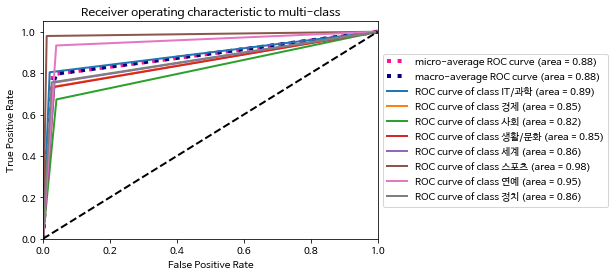

In [18]:
roc_auc_out1 = bm.Roc_Curve_MultiClass(test_x_by_m1, test_y2, classifier, le, np.unique(train_y2))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

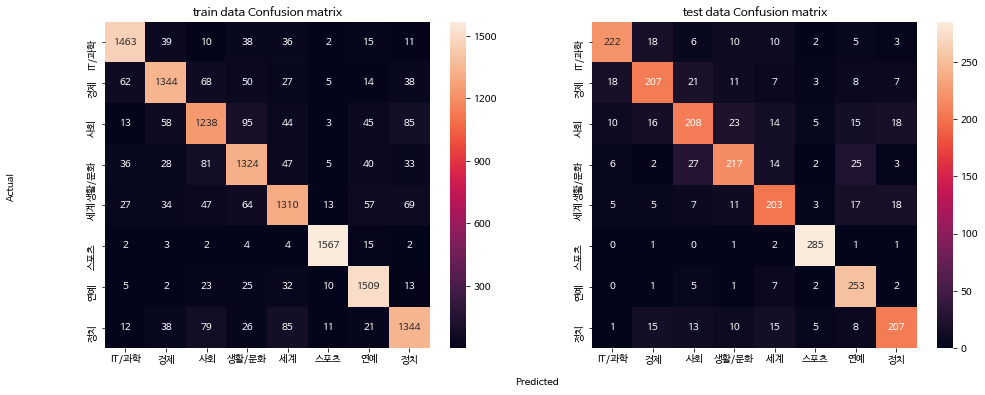

In [19]:
bm.ConfusionMatrix_To_Heatmap(train_x_by_m1, train_y2, test_x_by_m1, test_y2, classifier, le)

#### 분류모델 :  Random Forest Classifier

In [20]:
%%time
classifier2 = RandomForestClassifier(random_state=1234, n_estimators = 100, n_jobs=cores)
classifier2.fit(train_x_by_m1, train_y2)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_x_by_m1, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier2.predict(test_x_by_m1)))

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 4, 'oob_score': False, 'random_state': 1234, 'verbose': 0, 'warm_start': False}
score : 0.6825396825396826
classification report
             precision    recall  f1-score   support

          0       0.74      0.73      0.73       276
          1       0.62      0.66      0.64       282
          2       0.57      0.56      0.57       309
          3       0.71      0.53      0.60       296
          4       0.59      0.63      0.61       269
          5       0.83      0.96      0.89       291
          6       0.73      0.83      0.78       271
          7       0.66      0.58      0.61       274

avg / total       0.68      0.68      0.68      2268

CPU times: user 43.2 s, sys: 278 ms, to

In [21]:
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+train_x_by_m1_name, 'wb'))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

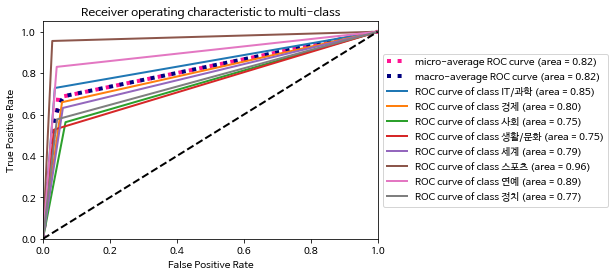

In [22]:
roc_auc_out2 = bm.Roc_Curve_MultiClass(test_x_by_m1, test_y2, classifier2, le, np.unique(train_y2))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

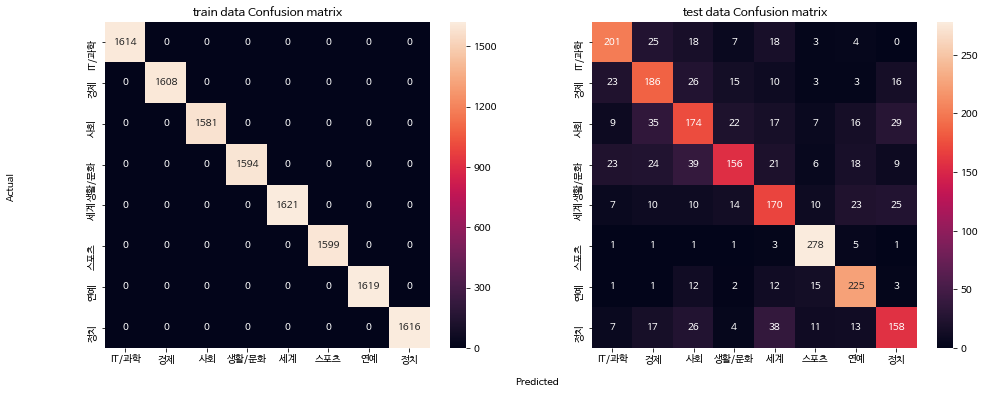

In [23]:
bm.ConfusionMatrix_To_Heatmap(train_x_by_m1, train_y2, test_x_by_m1, test_y2, classifier2, le)

#### 분류모델 : C-Support Vector Classification

In [24]:
%%time
classifier3 =  SVC(kernel = 'rbf', 
        cache_size= 1024, max_iter = 1500, verbose = True) 
classifier3.fit(train_x_by_m1, train_y2)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_x_by_m1, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier3.predict(test_x_by_m1)))

[LibSVM]{'C': 1.0, 'cache_size': 1024, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': 1500, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': True}
score : 0.8258377425044092
classification report
             precision    recall  f1-score   support

          0       0.88      0.83      0.85       276
          1       0.81      0.77      0.79       282
          2       0.69      0.79      0.73       309
          3       0.80      0.77      0.79       296
          4       0.78      0.80      0.79       269
          5       0.97      0.97      0.97       291
          6       0.84      0.94      0.89       271
          7       0.89      0.74      0.81       274

avg / total       0.83      0.83      0.83      2268

CPU times: user 1min 29s, sys: 560 ms, total: 1min 30s
Wall time: 1min 34s


In [25]:
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+train_x_by_m1_name, 'wb'))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

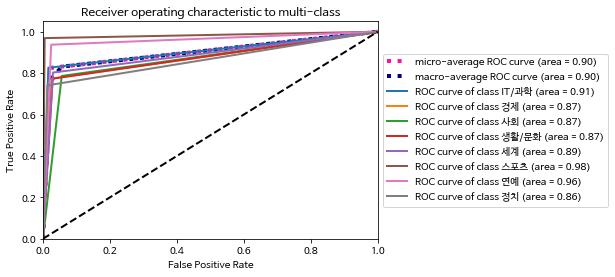

In [26]:
roc_auc_out3 = bm.Roc_Curve_MultiClass(test_x_by_m1, test_y2, classifier3, le, np.unique(train_y2))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

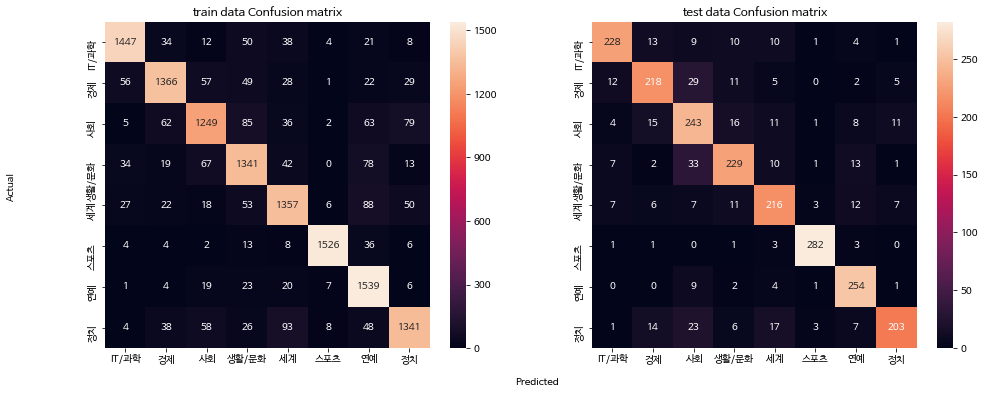

In [27]:
bm.ConfusionMatrix_To_Heatmap(train_x_by_m1, train_y2, test_x_by_m1, test_y2, classifier3, le)

#### XGBoost 

In [28]:
%%time
train_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x,train_x_by_m1))])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x, test_x_by_m1))])
test_vecs_w2v = scale(test_vecs_w2v)

y_test = np.array(test_y)
y_train = np.array(train_y)

12852it [00:00, 154748.35it/s]
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
2268it [00:00, 512674.83it/s]

CPU times: user 173 ms, sys: 99.1 ms, total: 272 ms
Wall time: 287 ms


In [29]:
%%time
dtrain = xgb.DMatrix(train_vecs_w2v, label= y_train)
dvalid = xgb.DMatrix(test_vecs_w2v, label = y_test)

CPU times: user 52.9 ms, sys: 32.8 ms, total: 85.7 ms
Wall time: 129 ms


In [30]:
%%time
max_depth = 5
subsample = 0.7
colsample_bytree = 0.7
params = {
    'objective' : 'multi:softmax', 
    'booster' : 'gbtree',
    'max_depth' : max_depth, 
    'subsample' : subsample,
    #'eval_metric' : 'auc', 
    'eval_metric' : 'mlogloss',
    'colsample_bytree' : colsample_bytree,
    'silent' : 1, 
    'eta' : 0.175,
    'nthread' : cores,
    'num_class' : 8
}
num_boost_round = 200
early_stopping_rounds = 10
test_size = 0.15

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals = watchlist,
                early_stopping_rounds = early_stopping_rounds, verbose_eval = True)

test_prediction = gbm.predict(xgb.DMatrix(test_vecs_w2v))
test_acc = accuracy_score(y_test, test_prediction)
print (test_acc)
gbm.save_model(saveClassifierPath+'XGBoost_'+train_x_by_m1_name)

[0]	train-mlogloss:1.93838	eval-mlogloss:1.96736
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 10 rounds.
[1]	train-mlogloss:1.81692	eval-mlogloss:1.87101
[2]	train-mlogloss:1.71326	eval-mlogloss:1.7917
[3]	train-mlogloss:1.62255	eval-mlogloss:1.71806
[4]	train-mlogloss:1.53994	eval-mlogloss:1.65501
[5]	train-mlogloss:1.46628	eval-mlogloss:1.59966
[6]	train-mlogloss:1.40026	eval-mlogloss:1.55218
[7]	train-mlogloss:1.33896	eval-mlogloss:1.50758
[8]	train-mlogloss:1.28298	eval-mlogloss:1.46489
[9]	train-mlogloss:1.2303	eval-mlogloss:1.42428
[10]	train-mlogloss:1.18148	eval-mlogloss:1.38581
[11]	train-mlogloss:1.13609	eval-mlogloss:1.35052
[12]	train-mlogloss:1.09232	eval-mlogloss:1.32001
[13]	train-mlogloss:1.05243	eval-mlogloss:1.29005
[14]	train-mlogloss:1.01541	eval-mlogloss:1.26231
[15]	train-mlogloss:0.980086	eval-mlogloss:1.23779
[16]	train-mlogloss:0.94628	eval-mlogloss:1.21102
[17]	train

[156]	train-mlogloss:0.03038	eval-mlogloss:0.591497
[157]	train-mlogloss:0.029762	eval-mlogloss:0.590602
[158]	train-mlogloss:0.029165	eval-mlogloss:0.590834
[159]	train-mlogloss:0.028609	eval-mlogloss:0.59
[160]	train-mlogloss:0.028081	eval-mlogloss:0.589469
[161]	train-mlogloss:0.027617	eval-mlogloss:0.588989
[162]	train-mlogloss:0.027107	eval-mlogloss:0.588444
[163]	train-mlogloss:0.026635	eval-mlogloss:0.587742
[164]	train-mlogloss:0.026166	eval-mlogloss:0.587351
[165]	train-mlogloss:0.025731	eval-mlogloss:0.58692
[166]	train-mlogloss:0.025244	eval-mlogloss:0.586559
[167]	train-mlogloss:0.024779	eval-mlogloss:0.585939
[168]	train-mlogloss:0.024348	eval-mlogloss:0.585542
[169]	train-mlogloss:0.023926	eval-mlogloss:0.585678
[170]	train-mlogloss:0.023474	eval-mlogloss:0.585364
[171]	train-mlogloss:0.023055	eval-mlogloss:0.584406
[172]	train-mlogloss:0.022684	eval-mlogloss:0.583294
[173]	train-mlogloss:0.022291	eval-mlogloss:0.582993
[174]	train-mlogloss:0.021922	eval-mlogloss:0.582689

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

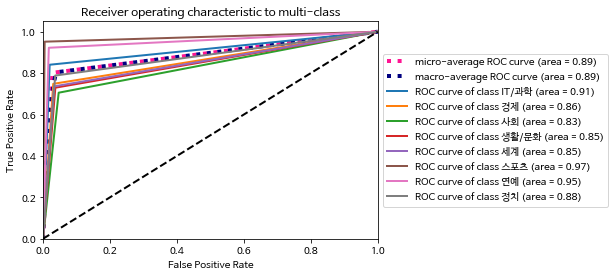

In [31]:
roc_auc_out4 = bm.Roc_Curve_MultiClass(xgb.DMatrix(test_vecs_w2v), test_y2, gbm, le, np.unique(train_y2))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

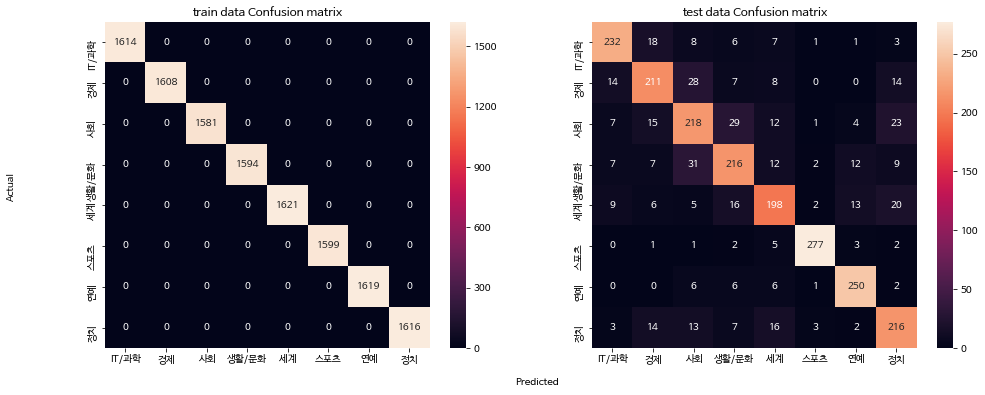

In [32]:
bm.ConfusionMatrix_To_Heatmap(xgb.DMatrix(train_vecs_w2v), train_y2, xgb.DMatrix(test_vecs_w2v), test_y2, gbm, le)

In [33]:
del classifier
del classifier2
del classifier3
del gbm

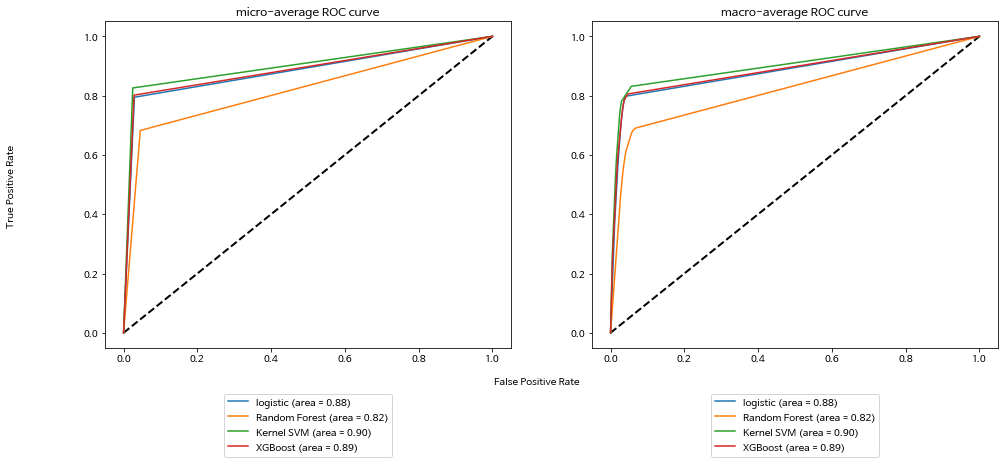

In [34]:
bm.Plot_Roc_Curver_Micro_Macro(roc_auc_out1, roc_auc_out2, roc_auc_out3, roc_auc_out4)

#### 분류모델 : Neural Network

In [35]:
y_test2 = np_utils.to_categorical(y_test,8)
y_train2 = np_utils.to_categorical(y_train,8)

In [36]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=500))
model.add(Dropout(0.3))
model.add(Dense(32, activation = 'sigmoid', kernel_regularizer=l2(0.1)))
model.add(Dropout(0.15))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='adadelta',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train2, epochs=300,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test2, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

HBox(children=(IntProgress(value=0, description='Training', max=300), HTML(value='')))


Score: 1.0092
Accuracy: 0.8272


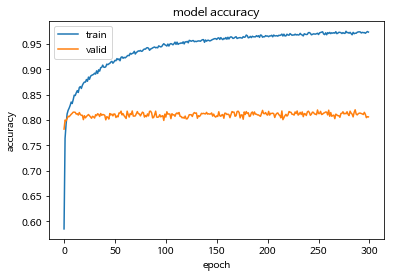

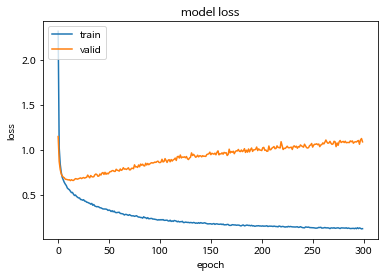

In [37]:
bm.plot_history(history)

In [38]:
model.save(saveClassifierPath+'NeuralNetwork_1_'+train_x_by_m1_name)

In [39]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=500))
model.add(Dense(64, activation='sigmoid', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(32, activation = 'relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train2, epochs=300,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test2, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

HBox(children=(IntProgress(value=0, description='Training', max=300), HTML(value='')))


Score: 1.4583
Accuracy: 0.8131


In [40]:
model.save(saveClassifierPath+'NeuralNetwork_2_'+train_x_by_m1_name)

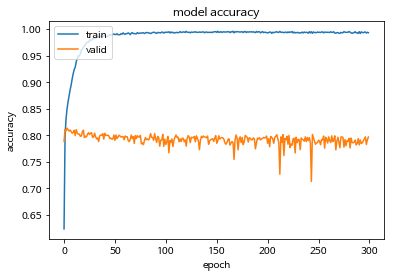

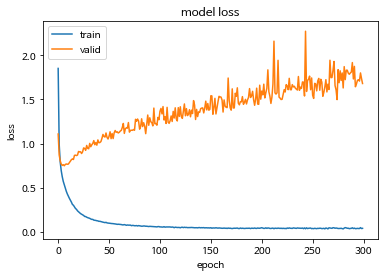

In [41]:
bm.plot_history(history)

In [42]:
del train_x_by_m1
del train_x_by_m1_name
del test_x_by_m1
del test_x_by_m1_name

### model2

In [43]:
train_x_by_m2_name = 'train_x_Doc2Vec-dm-c-d500-n7-w5-mc5-s0.001-t4-ct'
train_x_by_m2 = pickle.load(open(saveTrainPath+train_x_by_m2_name, 'rb'))
train_y = pickle.load(open(saveTrainPath+'train_category_y_ct_for_news_classification', 'rb'))
train_y2 = np.array([y[0] for y in tqdm(train_y)])
len(train_y), len(train_x_by_m2)

100%|██████████| 12852/12852 [00:00<00:00, 1771507.28it/s]


(12852, 12852)

In [44]:
test_x_by_m2_name = 'test_x_Doc2Vec-dm-c-d500-n7-w5-mc5-s0.001-t4-ct'
test_x_by_m2 = pickle.load(open(saveTrainPath+test_x_by_m2_name, 'rb'))
test_y = pickle.load(open(saveTrainPath+'test_category_y_ct_for_news_classification', 'rb'))
test_y2 = np.array([y[0] for y in tqdm(test_y)])
len(test_y), len(test_x_by_m2)

100%|██████████| 2268/2268 [00:00<00:00, 1372087.33it/s]


(2268, 2268)

#### 분류모델 : Logistic Regression

In [45]:
%%time
classifier = LogisticRegression(random_state=1234, max_iter = 250, n_jobs=cores)
classifier.fit(train_x_by_m2, train_y2)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_x_by_m2, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier.predict(test_x_by_m2)))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(self.n_jobs))


{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 250, 'multi_class': 'ovr', 'n_jobs': 4, 'penalty': 'l2', 'random_state': 1234, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
score : 0.6970899470899471
classification report
             precision    recall  f1-score   support

          0       0.85      0.79      0.82       276
          1       0.67      0.73      0.70       282
          2       0.63      0.64      0.63       309
          3       0.64      0.50      0.56       296
          4       0.61      0.62      0.62       269
          5       0.84      0.96      0.89       291
          6       0.74      0.66      0.70       271
          7       0.60      0.67      0.63       274

avg / total       0.70      0.70      0.69      2268

CPU times: user 27.9 s, sys: 142 ms, total: 28 s
Wall time: 28.1 s


In [46]:
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+train_x_by_m2_name, 'wb'))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

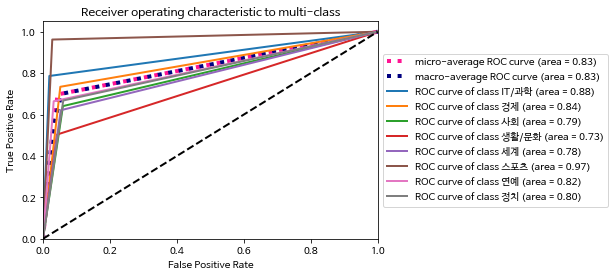

In [47]:
roc_auc_out1 = bm.Roc_Curve_MultiClass(test_x_by_m2, test_y2, classifier, le, np.unique(train_y2))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

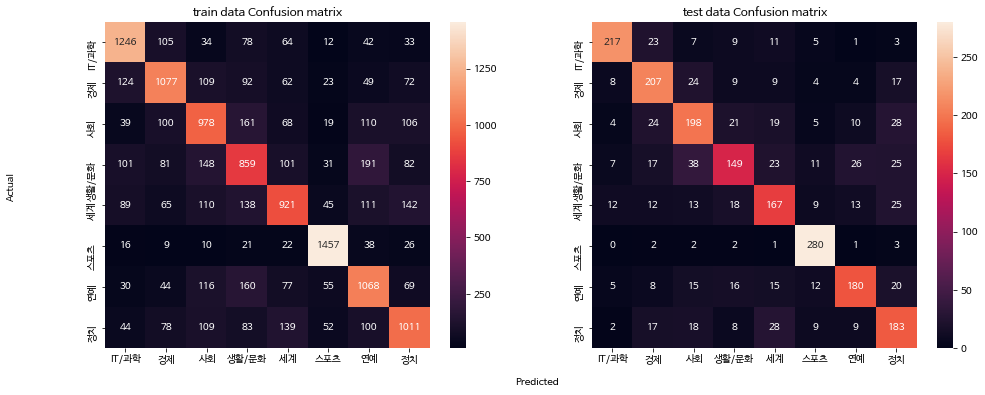

In [48]:
bm.ConfusionMatrix_To_Heatmap(train_x_by_m2, train_y2, test_x_by_m2, test_y2, classifier, le)

#### 분류모델 :  Random Forest Classifier

In [49]:
%%time
classifier2 = RandomForestClassifier(random_state=1234, n_estimators = 100, n_jobs=cores)
classifier2.fit(train_x_by_m2, train_y2)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_x_by_m2, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier2.predict(test_x_by_m2)))

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 4, 'oob_score': False, 'random_state': 1234, 'verbose': 0, 'warm_start': False}
score : 0.6335978835978836
classification report
             precision    recall  f1-score   support

          0       0.73      0.78      0.76       276
          1       0.63      0.70      0.66       282
          2       0.58      0.64      0.61       309
          3       0.56      0.34      0.42       296
          4       0.56      0.59      0.57       269
          5       0.79      0.95      0.86       291
          6       0.64      0.49      0.56       271
          7       0.53      0.58      0.55       274

avg / total       0.63      0.63      0.62      2268

CPU times: user 48.3 s, sys: 306 ms, to

In [50]:
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+train_x_by_m2_name, 'wb'))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

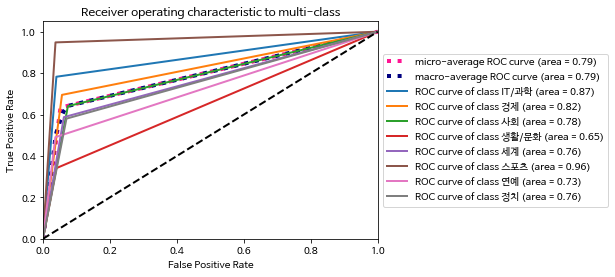

In [51]:
roc_auc_out2 = bm.Roc_Curve_MultiClass(test_x_by_m2, test_y2, classifier2, le, np.unique(train_y2))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

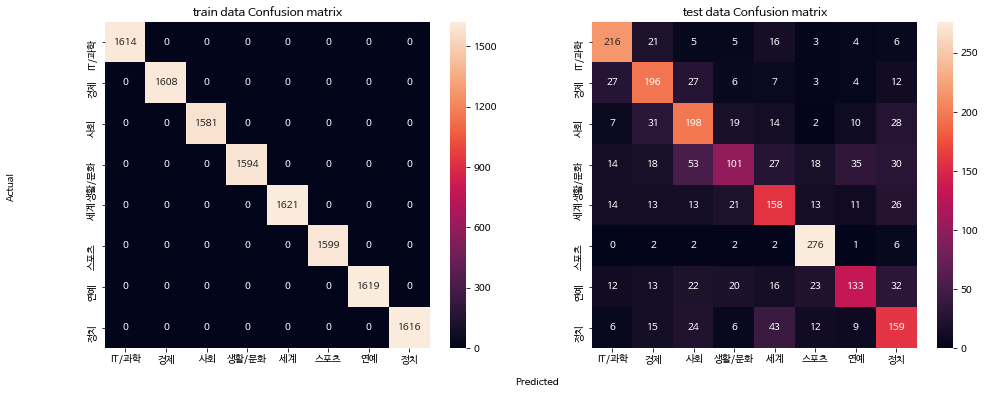

In [52]:
bm.ConfusionMatrix_To_Heatmap(train_x_by_m2, train_y2, test_x_by_m2, test_y2, classifier2, le)

#### 분류모델 : C-Support Vector Classification

In [53]:
%%time
classifier3 =  SVC(kernel = 'rbf', 
        cache_size= 1024, max_iter = 1500, verbose = True) 
classifier3.fit(train_x_by_m2, train_y2)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_x_by_m2, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier3.predict(test_x_by_m2)))

[LibSVM]{'C': 1.0, 'cache_size': 1024, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': 1500, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': True}
score : 0.6441798941798942
classification report
             precision    recall  f1-score   support

          0       0.80      0.76      0.78       276
          1       0.67      0.67      0.67       282
          2       0.55      0.65      0.60       309
          3       0.56      0.33      0.42       296
          4       0.61      0.58      0.60       269
          5       0.84      0.95      0.89       291
          6       0.63      0.58      0.60       271
          7       0.49      0.64      0.56       274

avg / total       0.64      0.64      0.64      2268

CPU times: user 2min 18s, sys: 375 ms, total: 2min 18s
Wall time: 3min 6s


In [54]:
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+train_x_by_m2_name, 'wb'))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

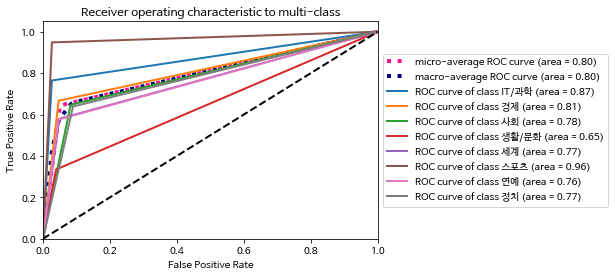

In [55]:
roc_auc_out3 = bm.Roc_Curve_MultiClass(test_x_by_m2, test_y2, classifier3, le, np.unique(train_y2))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

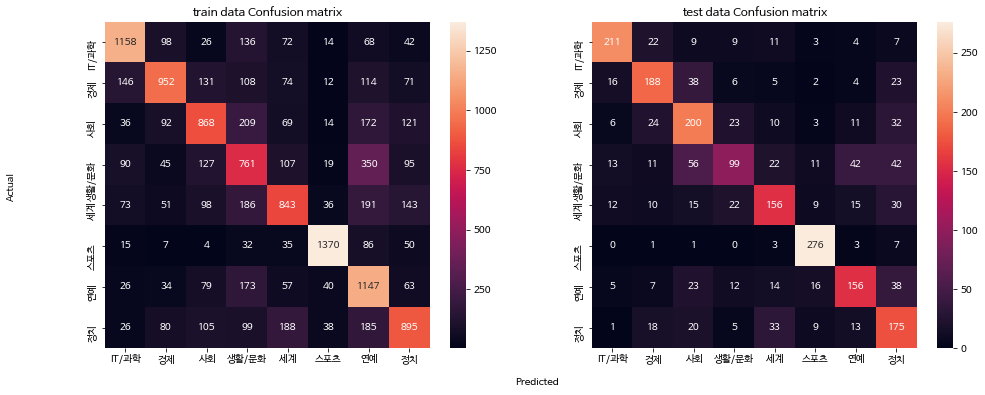

In [56]:
bm.ConfusionMatrix_To_Heatmap(train_x_by_m2, train_y2, test_x_by_m2, test_y2, classifier3, le)

#### XGBoost 

In [57]:
%%time
train_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x,train_x_by_m2))])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x, test_x_by_m2))])
test_vecs_w2v = scale(test_vecs_w2v)

y_test = np.array(test_y)
y_train = np.array(train_y)

12852it [00:00, 577700.09it/s]
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
2268it [00:00, 641059.47it/s]

CPU times: user 120 ms, sys: 39.5 ms, total: 159 ms
Wall time: 159 ms


In [58]:
%%time
dtrain = xgb.DMatrix(train_vecs_w2v, label=y_train)
dvalid = xgb.DMatrix(test_vecs_w2v, label = y_test)

CPU times: user 25.3 ms, sys: 5.72 ms, total: 31 ms
Wall time: 31 ms


In [59]:
%%time
max_depth = 5
subsample = 0.7
colsample_bytree = 0.7
params = {
    'objective' : 'multi:softmax', 
    'booster' : 'gbtree',
    'max_depth' : max_depth, 
    'subsample' : subsample,
    #'eval_metric' : 'auc', 
    'eval_metric' : 'mlogloss',
    'colsample_bytree' : colsample_bytree,
    'silent' : 1, 
    'eta' : 0.175,
    'nthread' : cores,
    'num_class' : 8
}
num_boost_round = 200
early_stopping_rounds = 10
test_size = 0.15

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals = watchlist,
                early_stopping_rounds = early_stopping_rounds, verbose_eval = True)

test_prediction = gbm.predict(xgb.DMatrix(test_vecs_w2v))
test_acc = accuracy_score(y_test, test_prediction)
print (test_acc)
gbm.save_model(saveClassifierPath+'XGBoost_'+train_x_by_m2_name)

[0]	train-mlogloss:1.92348	eval-mlogloss:1.91891
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 10 rounds.
[1]	train-mlogloss:1.8001	eval-mlogloss:1.79477
[2]	train-mlogloss:1.69707	eval-mlogloss:1.69466
[3]	train-mlogloss:1.61003	eval-mlogloss:1.61256
[4]	train-mlogloss:1.53614	eval-mlogloss:1.54459
[5]	train-mlogloss:1.46905	eval-mlogloss:1.48432
[6]	train-mlogloss:1.40968	eval-mlogloss:1.43482
[7]	train-mlogloss:1.35631	eval-mlogloss:1.38926
[8]	train-mlogloss:1.30758	eval-mlogloss:1.34888
[9]	train-mlogloss:1.2624	eval-mlogloss:1.3125
[10]	train-mlogloss:1.22102	eval-mlogloss:1.27978
[11]	train-mlogloss:1.18316	eval-mlogloss:1.25094
[12]	train-mlogloss:1.14817	eval-mlogloss:1.22443
[13]	train-mlogloss:1.11584	eval-mlogloss:1.20239
[14]	train-mlogloss:1.0851	eval-mlogloss:1.18085
[15]	train-mlogloss:1.05593	eval-mlogloss:1.16194
[16]	train-mlogloss:1.02915	eval-mlogloss:1.14497
[17]	train-ml

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

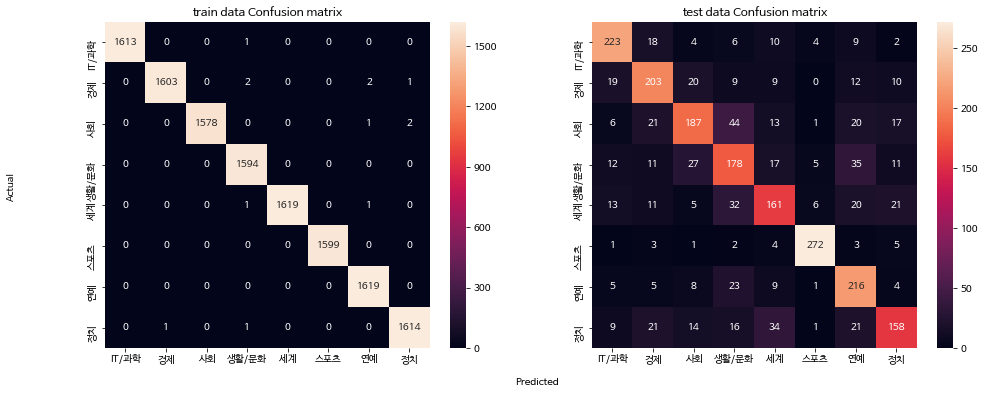

In [60]:
bm.ConfusionMatrix_To_Heatmap(xgb.DMatrix(train_vecs_w2v), train_y2, xgb.DMatrix(test_vecs_w2v), test_y2, gbm, le)


/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

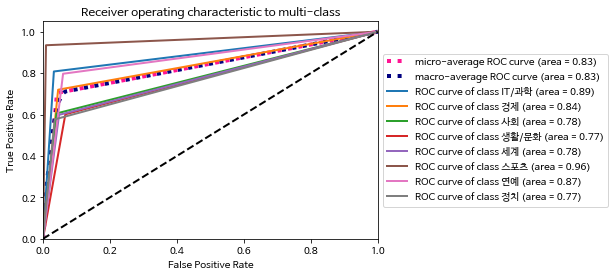

In [61]:
roc_auc_out4 = bm.Roc_Curve_MultiClass(xgb.DMatrix(test_vecs_w2v), test_y2, gbm, le, np.unique(train_y2))

In [62]:
del classifier
del classifier2
del classifier3
del gbm

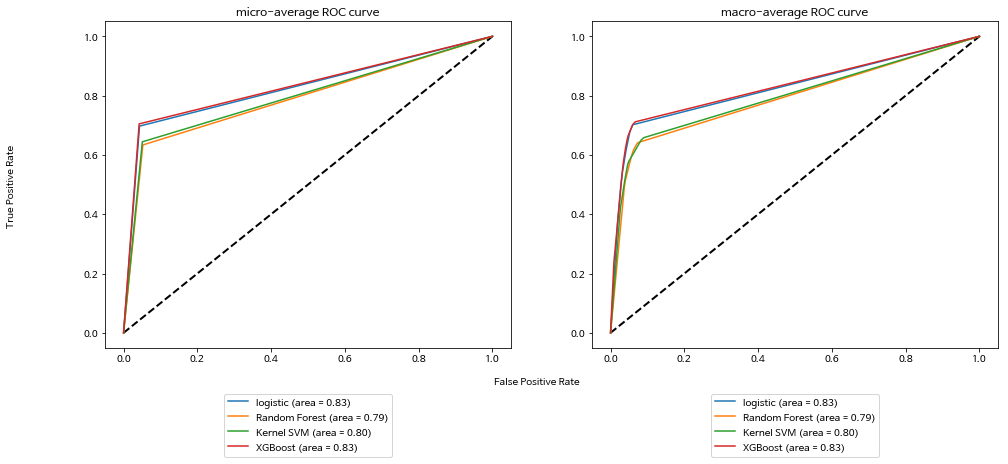

In [63]:
bm.Plot_Roc_Curver_Micro_Macro(roc_auc_out1, roc_auc_out2, roc_auc_out3, roc_auc_out4)

#### 분류모델 : Neural Network

In [64]:
y_test2 = np_utils.to_categorical(y_test,8)
y_train2 = np_utils.to_categorical(y_train,8)

In [65]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=500))
model.add(Dropout(0.3))
model.add(Dense(32, activation = 'sigmoid', kernel_regularizer=l2(0.1)))
model.add(Dropout(0.15))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='adadelta',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train2, epochs=300,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test2, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

HBox(children=(IntProgress(value=0, description='Training', max=300), HTML(value='')))


Score: 1.1049
Accuracy: 0.7147


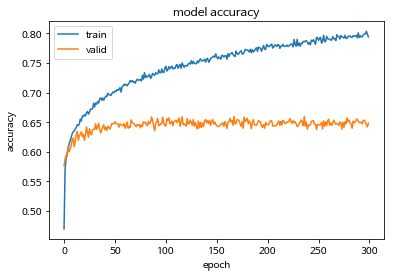

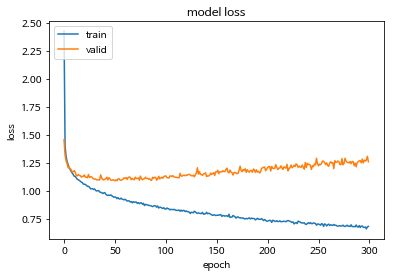

In [66]:
bm.plot_history(history)

In [67]:
model.save(saveClassifierPath+'NeuralNetwork_1_'+train_x_by_m2_name)

In [68]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=500))
model.add(Dense(64, activation='sigmoid', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(32, activation = 'relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train2, epochs=300,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test2, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

HBox(children=(IntProgress(value=0, description='Training', max=300), HTML(value='')))


Score: 2.6566
Accuracy: 0.6530


In [69]:
model.save(saveClassifierPath+'NeuralNetwork_2_'+train_x_by_m2_name)

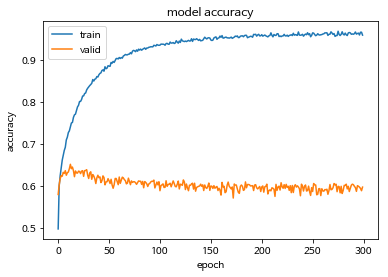

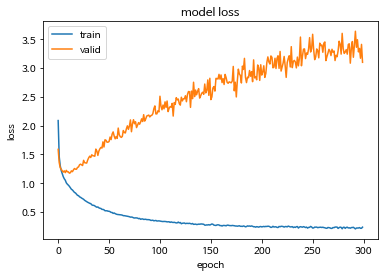

In [70]:
bm.plot_history(history)

In [71]:
del train_x_by_m2
del train_x_by_m2_name
del test_x_by_m2
del test_x_by_m2_name

### model3

In [72]:
train_x_by_m3_name = 'train_x_Doc2Vec-dbow-d500-n7-mc5-s0.001-t4-ct'
train_x_by_m3 = pickle.load(open(saveTrainPath+train_x_by_m3_name, 'rb'))
train_y = pickle.load(open(saveTrainPath+'train_category_y_ct_for_news_classification', 'rb'))
train_y2 = np.array([y[0] for y in tqdm(train_y)])
len(train_y), len(train_x_by_m3)

100%|██████████| 12852/12852 [00:00<00:00, 1732339.08it/s]


(12852, 12852)

In [73]:
test_x_by_m3_name = 'test_x_Doc2Vec-dbow-d500-n7-mc5-s0.001-t4-ct'
test_x_by_m3 = pickle.load(open(saveTrainPath+test_x_by_m3_name, 'rb'))
test_y = pickle.load(open(saveTrainPath+'test_category_y_ct_for_news_classification', 'rb'))
test_y2 = np.array([y[0] for y in tqdm(test_y)])
len(test_y), len(test_x_by_m3)

100%|██████████| 2268/2268 [00:00<00:00, 1350082.53it/s]


(2268, 2268)

#### 분류모델 : Logistic Regression

In [74]:
%%time
classifier = LogisticRegression(random_state=1234, max_iter = 250, n_jobs=cores)
classifier.fit(train_x_by_m3, train_y2)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_x_by_m3, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier.predict(test_x_by_m3)))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(self.n_jobs))


{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 250, 'multi_class': 'ovr', 'n_jobs': 4, 'penalty': 'l2', 'random_state': 1234, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
score : 0.8747795414462081
classification report
             precision    recall  f1-score   support

          0       0.89      0.89      0.89       276
          1       0.82      0.85      0.83       282
          2       0.81      0.75      0.78       309
          3       0.83      0.83      0.83       296
          4       0.83      0.88      0.85       269
          5       0.98      0.98      0.98       291
          6       0.98      0.99      0.99       271
          7       0.85      0.85      0.85       274

avg / total       0.87      0.87      0.87      2268

CPU times: user 10.9 s, sys: 77.9 ms, total: 10.9 s
Wall time: 11.1 s


In [75]:
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+train_x_by_m3_name, 'wb'))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

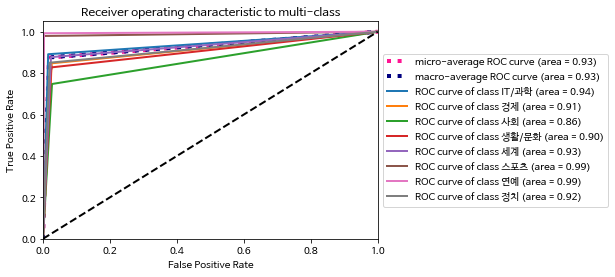

In [76]:
roc_auc_out1 = bm.Roc_Curve_MultiClass(test_x_by_m3, test_y2, classifier, le, np.unique(train_y2))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

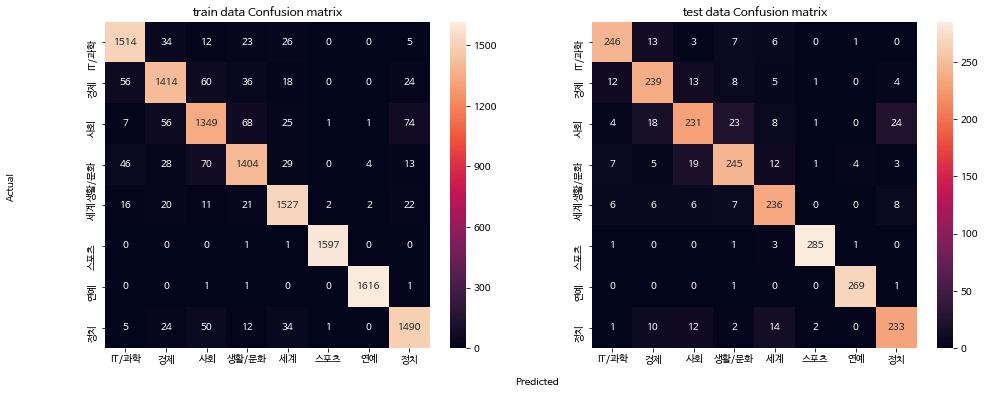

In [77]:
bm.ConfusionMatrix_To_Heatmap(train_x_by_m3, train_y2, test_x_by_m3, test_y2, classifier, le)

#### 분류모델 :  Random Forest Classifier

In [78]:
%%time
classifier2 = RandomForestClassifier(random_state=1234, n_estimators = 100, n_jobs=cores)
classifier2.fit(train_x_by_m3, train_y2)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_x_by_m3, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier2.predict(test_x_by_m3)))

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 4, 'oob_score': False, 'random_state': 1234, 'verbose': 0, 'warm_start': False}
score : 0.7314814814814815
classification report
             precision    recall  f1-score   support

          0       0.71      0.81      0.76       276
          1       0.68      0.62      0.65       282
          2       0.69      0.59      0.63       309
          3       0.75      0.58      0.65       296
          4       0.69      0.72      0.71       269
          5       0.87      0.89      0.88       291
          6       0.77      0.98      0.86       271
          7       0.67      0.69      0.68       274

avg / total       0.73      0.73      0.73      2268

CPU times: user 42.1 s, sys: 246 ms, to

In [79]:
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+train_x_by_m3_name, 'wb'))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

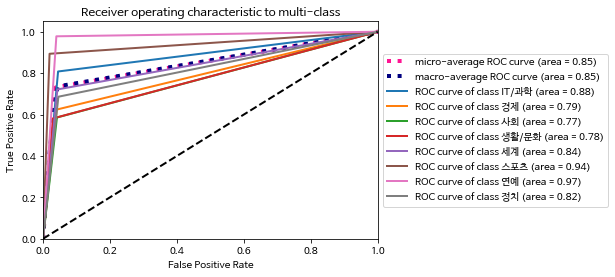

In [80]:
roc_auc_out2 = bm.Roc_Curve_MultiClass(test_x_by_m3, test_y2, classifier2, le, np.unique(train_y2))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

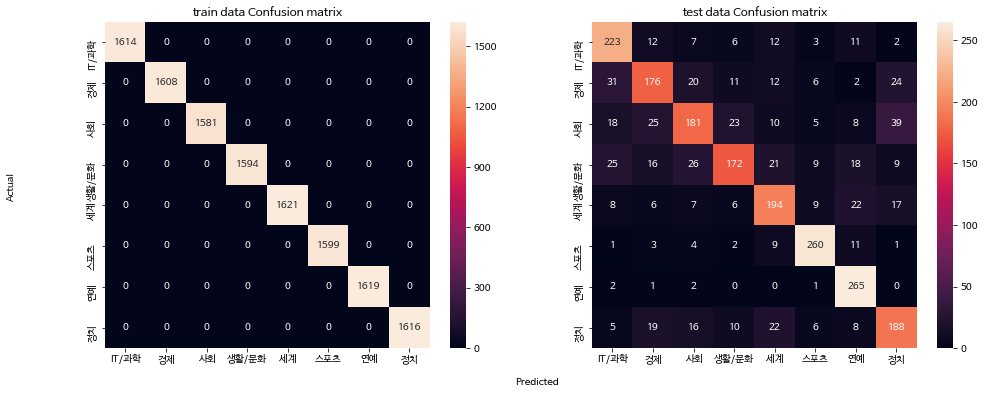

In [81]:
bm.ConfusionMatrix_To_Heatmap(train_x_by_m3, train_y2, test_x_by_m3, test_y2, classifier2, le)

#### 분류모델 : C-Support Vector Classification

In [82]:
%%time
classifier3 =  SVC(kernel = 'rbf', 
        cache_size= 1024, max_iter = 1500, verbose = True) 
classifier3.fit(train_x_by_m3, train_y2)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_x_by_m3, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier3.predict(test_x_by_m3)))

[LibSVM]{'C': 1.0, 'cache_size': 1024, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': 1500, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': True}
score : 0.8761022927689595
classification report
             precision    recall  f1-score   support

          0       0.88      0.91      0.90       276
          1       0.82      0.84      0.83       282
          2       0.80      0.74      0.77       309
          3       0.86      0.83      0.84       296
          4       0.85      0.90      0.87       269
          5       0.98      0.97      0.98       291
          6       0.96      0.99      0.97       271
          7       0.86      0.85      0.86       274

avg / total       0.88      0.88      0.88      2268

CPU times: user 1min 28s, sys: 203 ms, total: 1min 29s
Wall time: 1min 29s


In [83]:
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+train_x_by_m3_name, 'wb'))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

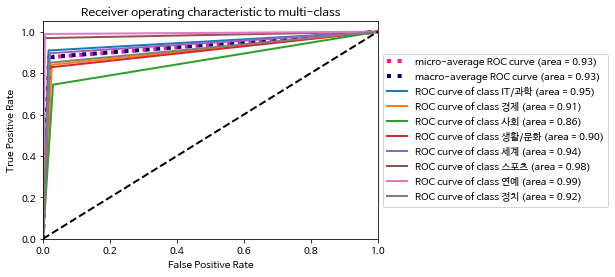

In [84]:
roc_auc_out3 = bm.Roc_Curve_MultiClass(test_x_by_m3, test_y2, classifier3, le, np.unique(train_y2))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

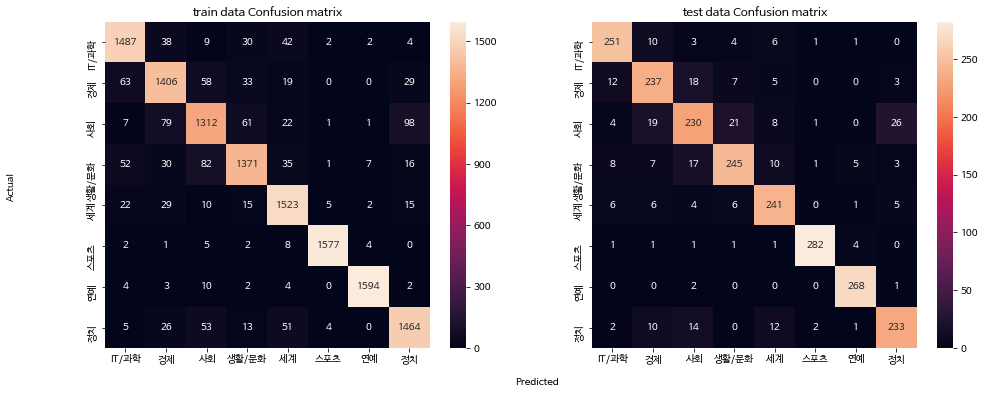

In [85]:
bm.ConfusionMatrix_To_Heatmap(train_x_by_m3, train_y2, test_x_by_m3, test_y2, classifier3, le)

#### XGBoost 

In [86]:
%%time
train_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x,train_x_by_m3))])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x, test_x_by_m3))])
test_vecs_w2v = scale(test_vecs_w2v)

y_test = np.array(test_y)
y_train = np.array(train_y)

12852it [00:00, 539154.39it/s]
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
2268it [00:00, 530782.36it/s]

CPU times: user 115 ms, sys: 30.8 ms, total: 146 ms
Wall time: 140 ms


In [87]:
%%time
dtrain = xgb.DMatrix(train_vecs_w2v, label=y_train)
dvalid = xgb.DMatrix(test_vecs_w2v, label = y_test)

CPU times: user 36.4 ms, sys: 20 ms, total: 56.4 ms
Wall time: 53.3 ms


In [88]:
%%time
max_depth = 5
subsample = 0.7
colsample_bytree = 0.7
params = {
    'objective' : 'multi:softmax', 
    'booster' : 'gbtree',
    'max_depth' : max_depth, 
    'subsample' : subsample,
    #'eval_metric' : 'auc', 
    'eval_metric' : 'mlogloss',
    'colsample_bytree' : colsample_bytree,
    'silent' : 1, 
    'eta' : 0.175,
    'nthread' : cores,
    'num_class' : 8
}
num_boost_round = 200
early_stopping_rounds = 10
test_size = 0.15

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals = watchlist,
                early_stopping_rounds = early_stopping_rounds, verbose_eval = True)

test_prediction = gbm.predict(xgb.DMatrix(test_vecs_w2v))
test_acc = accuracy_score(y_test, test_prediction)
print (test_acc)
gbm.save_model(saveClassifierPath+'XGBoost_'+train_x_by_m3_name)

[0]	train-mlogloss:1.94292	eval-mlogloss:1.97243
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 10 rounds.
[1]	train-mlogloss:1.82298	eval-mlogloss:1.87567
[2]	train-mlogloss:1.72131	eval-mlogloss:1.79817
[3]	train-mlogloss:1.63086	eval-mlogloss:1.73022
[4]	train-mlogloss:1.54844	eval-mlogloss:1.66742
[5]	train-mlogloss:1.47397	eval-mlogloss:1.61083
[6]	train-mlogloss:1.4061	eval-mlogloss:1.55853
[7]	train-mlogloss:1.34356	eval-mlogloss:1.51245
[8]	train-mlogloss:1.28636	eval-mlogloss:1.4715
[9]	train-mlogloss:1.23385	eval-mlogloss:1.43443
[10]	train-mlogloss:1.18321	eval-mlogloss:1.39695
[11]	train-mlogloss:1.1358	eval-mlogloss:1.3604
[12]	train-mlogloss:1.09094	eval-mlogloss:1.32705
[13]	train-mlogloss:1.04865	eval-mlogloss:1.29624
[14]	train-mlogloss:1.00792	eval-mlogloss:1.2655
[15]	train-mlogloss:0.970421	eval-mlogloss:1.23932
[16]	train-mlogloss:0.934674	eval-mlogloss:1.21477
[17]	train-m

[156]	train-mlogloss:0.02442	eval-mlogloss:0.479756
[157]	train-mlogloss:0.023959	eval-mlogloss:0.479285
[158]	train-mlogloss:0.023491	eval-mlogloss:0.478516
[159]	train-mlogloss:0.023063	eval-mlogloss:0.477685
[160]	train-mlogloss:0.022608	eval-mlogloss:0.476932
[161]	train-mlogloss:0.022173	eval-mlogloss:0.476498
[162]	train-mlogloss:0.021718	eval-mlogloss:0.476176
[163]	train-mlogloss:0.021305	eval-mlogloss:0.475229
[164]	train-mlogloss:0.020925	eval-mlogloss:0.474968
[165]	train-mlogloss:0.020562	eval-mlogloss:0.474065
[166]	train-mlogloss:0.02019	eval-mlogloss:0.473163
[167]	train-mlogloss:0.019802	eval-mlogloss:0.47306
[168]	train-mlogloss:0.019421	eval-mlogloss:0.471953
[169]	train-mlogloss:0.019041	eval-mlogloss:0.471873
[170]	train-mlogloss:0.018729	eval-mlogloss:0.471263
[171]	train-mlogloss:0.018398	eval-mlogloss:0.471292
[172]	train-mlogloss:0.018065	eval-mlogloss:0.470566
[173]	train-mlogloss:0.017763	eval-mlogloss:0.470149
[174]	train-mlogloss:0.017476	eval-mlogloss:0.469

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

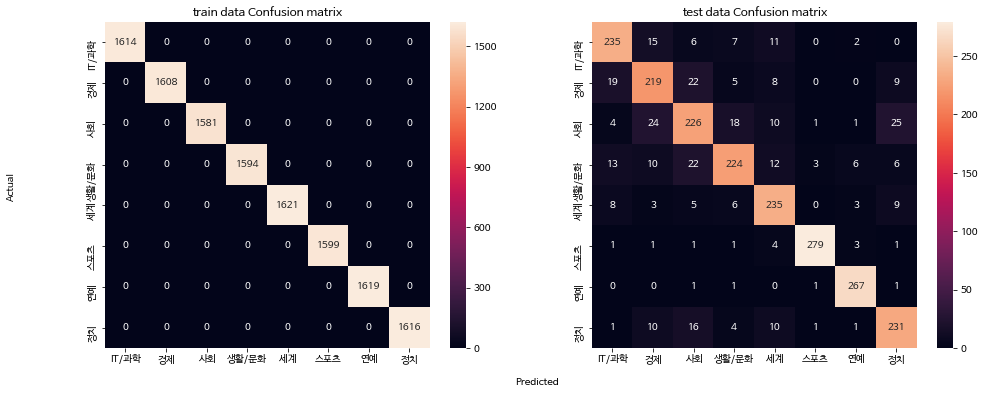

In [89]:
bm.ConfusionMatrix_To_Heatmap(xgb.DMatrix(train_vecs_w2v), train_y2, xgb.DMatrix(test_vecs_w2v), test_y2, gbm, le)


/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

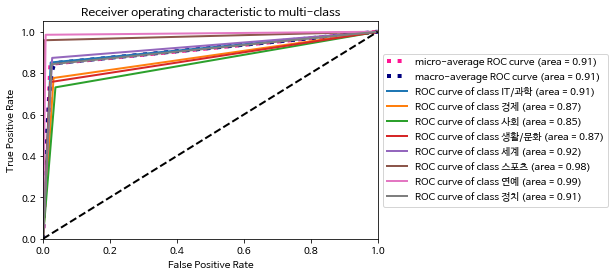

In [90]:
roc_auc_out4 = bm.Roc_Curve_MultiClass(xgb.DMatrix(test_vecs_w2v), test_y2, gbm, le, np.unique(train_y2))

In [91]:
del classifier
del classifier2
del classifier3
del gbm

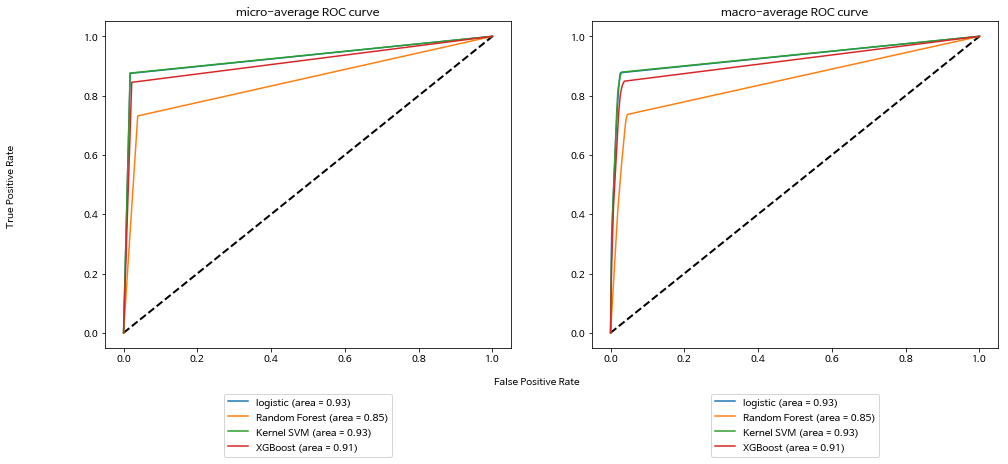

In [92]:
bm.Plot_Roc_Curver_Micro_Macro(roc_auc_out1, roc_auc_out2, roc_auc_out3, roc_auc_out4)

#### 분류모델 : Neural Network

In [ ]:
y_test2 = np_utils.to_categorical(y_test,8)
y_train2 = np_utils.to_categorical(y_train,8)

In [ ]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=500))
model.add(Dropout(0.3))
model.add(Dense(32, activation = 'sigmoid', kernel_regularizer=l2(0.1)))
model.add(Dropout(0.15))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='adadelta',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train2, epochs=300,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test2, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

HBox(children=(IntProgress(value=0, description='Training', max=300), HTML(value='')))

In [ ]:
bm.plot_history(history)

In [ ]:
model.save(saveClassifierPath+'NeuralNetwork_1_'+train_x_by_m3_name)

In [ ]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=500))
model.add(Dense(64, activation='sigmoid', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(32, activation = 'relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train2, epochs=300,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test2, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

In [ ]:
model.save(saveClassifierPath+'NeuralNetwork_2_'+train_x_by_m3_name)

In [ ]:
bm.plot_history(history)

In [ ]:
del train_x_by_m3
del train_x_by_m3_name
del test_x_by_m3
del test_x_by_m3_name

### Mecab

### Load Model

In [ ]:
model1 = doc2vec.Doc2Vec.load(loadModelPath+'doc2vec_size-500_epoch-20_window-10_negative-7_hs-0_dm-1_dm_concat-0_dm_mean-1_by-mecab.model')
model2 = doc2vec.Doc2Vec.load(loadModelPath+'doc2vec_size-500_epoch-20_window-5_negative-7_hs-0_dm-1_dm_concat-1_dm_mean-0_by-mecab.model')
model3 = doc2vec.Doc2Vec.load(loadModelPath+'doc2vec_size-500_epoch-20_window-None_negative-7_hs-0_dm-0_dm_concat-0_dm_mean-0_by-mecab.model')

### Train dataset & test dataset

In [ ]:
trainName = './data/pre_data/news_train_test_Data/pre_data_doc2vec_train_for_news_classification_by_mecab.pickled'
testName = './data/pre_data/news_train_test_Data/pre_data_doc2vec_test_for_news_classification_by_mecab.pickled'

In [ ]:
train = pickle.load(open(trainName, 'rb'))
test = pickle.load(open(testName, 'rb'))

#### train dataset

In [ ]:
taggerName = 'mecab'
name1 = '-'.join(re.split('[\(\),\/]',str(model1)))+taggerName
if not os.path.isfile(saveTrainPath+'train_x_'+name1):
    train_x_by_m1 = bm.Get_Infer_Vector(train, model1)
    
    pickle.dump(train_x_by_m1,open(saveTrainPath+'train_x_'+name1,'wb'))
    del train_x_by_m1
    del name1
    
name2 = '-'.join(re.split('[\(\),\/]',str(model2)))+taggerName
if not os.path.isfile(saveTrainPath+'train_x_'+name2):
    train_x_by_m2 = bm.Get_Infer_Vector(train, model2)

    pickle.dump(train_x_by_m2,open(saveTrainPath+'train_x_'+name2,'wb'))
    del train_x_by_m2
    del name2

name3 = '-'.join(re.split('[\(\),\/]',str(model3)))+taggerName
if not os.path.isfile(saveTrainPath+'train_x_'+name3):
    train_x_by_m3 = bm.Get_Infer_Vector(train, model3)

    pickle.dump(train_x_by_m3,open(saveTrainPath+'train_x_'+name3,'wb'))
    del train_x_by_m3
    del name3

if not os.path.isfile(saveTrainPath+'train_category_y_mecab_for_news_classification'):
    train_category_y = [doc.category for doc in tqdm(train)]
    
    pickle.dump(train_category_y, open(saveTrainPath+'train_category_y_mecab_for_news_classification','wb'))
    del train_category_y
    
if not os.path.isfile(saveTrainPath+'train_tags_y_mecab_for_news_classification'):
    train_tags_y = [doc.tags for doc in tqdm(train)]
    
    pickle.dump(train_tags_y, open(saveTrainPath+'train_tags_y_mecab_for_news_classification','wb'))
    del train_tags_y

if 'train' in locals():
    del train

#### test dataset

In [ ]:
taggerName = 'mecab'
name1 = '-'.join(re.split('[\(\),\/]',str(model1)))+taggerName
if not os.path.isfile(saveTrainPath+'test_x_'+name1):
    test_x_by_m1 = bm.Get_Infer_Vector(test, model1)
    
    pickle.dump(test_x_by_m1,open(saveTrainPath+'test_x_'+name1,'wb'))
    del test_x_by_m1
    del name1
    
name2 = '-'.join(re.split('[\(\),\/]',str(model2)))+taggerName
if not os.path.isfile(saveTrainPath+'test_x_'+name2):
    test_x_by_m2 = bm.Get_Infer_Vector(test, model2)

    pickle.dump(test_x_by_m2,open(saveTrainPath+'test_x_'+name2,'wb'))
    del test_x_by_m2
    del name2

name3 = '-'.join(re.split('[\(\),\/]',str(model3)))+taggerName
if not os.path.isfile(saveTrainPath+'test_x_'+name3):
    test_x_by_m3 = bm.Get_Infer_Vector(test, model3)

    pickle.dump(test_x_by_m3,open(saveTrainPath+'test_x_'+name3,'wb'))
    del test_x_by_m3
    del name3

if not os.path.isfile(saveTrainPath+'test_category_y_mecab_for_news_classification'):
    test_category_y = [doc.category for doc in tqdm(test)]
    
    pickle.dump(test_category_y, open(saveTrainPath+'test_category_y_mecab_for_news_classification','wb'))
    del test_category_y
    
if not os.path.isfile(saveTrainPath+'test_tags_y_mecab_for_news_classification'):
    test_tags_y = [doc.tags for doc in tqdm(test)]
    
    pickle.dump(test_tags_y, open(saveTrainPath+'test_tags_y_mecab_for_news_classification','wb'))
    del test_tags_y

if 'test' in locals():
    del test

### model1

In [ ]:
train_x_by_m1_name = 'train_x_Doc2Vec-dm-m-d500-n7-w10-mc5-s0.001-t4-mecab'
train_x_by_m1 = pickle.load(open(saveTrainPath+train_x_by_m1_name, 'rb'))
train_y = pickle.load(open(saveTrainPath+'train_category_y_mecab_for_news_classification', 'rb'))
train_y2 = np.array([y[0] for y in tqdm(train_y)])
len(train_y), len(train_x_by_m1)

In [ ]:
test_x_by_m1_name = 'test_x_Doc2Vec-dm-m-d500-n7-w10-mc5-s0.001-t4-ct'
test_x_by_m1 = pickle.load(open(saveTrainPath+test_x_by_m1_name, 'rb'))
test_y = pickle.load(open(saveTrainPath+'test_category_y_mecab_for_news_classification', 'rb'))
test_y2 = np.array([y[0] for y in tqdm(test_y)])
len(test_y), len(test_x_by_m1)

#### 분류모델 : Logistic Regression

In [ ]:
%%time
classifier = LogisticRegression(random_state=1234, max_iter = 250, n_jobs=cores)
classifier.fit(train_x_by_m1, train_y2)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_x_by_m1, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier.predict(test_x_by_m1)))

In [ ]:
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+train_x_by_m1_name, 'wb'))

In [ ]:
roc_auc_out1 = bm.Roc_Curve_MultiClass(test_x_by_m1, test_y2, classifier, le, np.unique(train_y2))

In [ ]:
bm.ConfusionMatrix_To_Heatmap(train_x_by_m1, train_y2, test_x_by_m1, test_y2, classifier, le)

#### 분류모델 :  Random Forest Classifier

In [ ]:
%%time
classifier2 = RandomForestClassifier(random_state=1234, n_estimators = 100, n_jobs=cores)
classifier2.fit(train_x_by_m1, train_y2)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_x_by_m1, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier2.predict(test_x_by_m1)))

In [ ]:
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+train_x_by_m1_name, 'wb'))

In [ ]:
roc_auc_out2 = bm.Roc_Curve_MultiClass(test_x_by_m1, test_y2, classifier2, le, np.unique(train_y2))

In [ ]:
bm.ConfusionMatrix_To_Heatmap(train_x_by_m1, train_y2, test_x_by_m1, test_y2, classifier2, le)

#### 분류모델 : C-Support Vector Classification

In [ ]:
%%time
classifier3 =  SVC(kernel = 'rbf', 
        cache_size= 1024, max_iter = 1500, verbose = True) 
classifier3.fit(train_x_by_m1, train_y2)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_x_by_m1, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier3.predict(test_x_by_m1)))

In [ ]:
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+train_x_by_m1_name, 'wb'))

In [ ]:
roc_auc_out3 = bm.Roc_Curve_MultiClass(test_x_by_m1, test_y2, classifier3, le, np.unique(train_y2))

In [ ]:
bm.ConfusionMatrix_To_Heatmap(train_x_by_m1, train_y2, test_x_by_m1, test_y2, classifier3, le)

#### XGBoost 

In [ ]:
%%time
train_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x,train_x_by_m1))])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x, test_x_by_m1))])
test_vecs_w2v = scale(test_vecs_w2v)

y_test = np.array(test_y)
y_train = np.array(train_y)

In [ ]:
%%time
dtrain = xgb.DMatrix(train_vecs_w2v, label=y_train)
dvalid = xgb.DMatrix(test_vecs_w2v, label = y_test)

In [ ]:
%%time
max_depth = 5
subsample = 0.7
colsample_bytree = 0.7
params = {
    'objective' : 'multi:softmax', 
    'booster' : 'gbtree',
    'max_depth' : max_depth, 
    'subsample' : subsample,
    #'eval_metric' : 'auc', 
    'eval_metric' : 'mlogloss',
    'colsample_bytree' : colsample_bytree,
    'silent' : 1, 
    'eta' : 0.175,
    'nthread' : cores,
    'num_class' : 8
}
num_boost_round = 200
early_stopping_rounds = 10
test_size = 0.15

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals = watchlist,
                early_stopping_rounds = early_stopping_rounds, verbose_eval = True)

test_prediction = gbm.predict(xgb.DMatrix(test_vecs_w2v))
test_acc = accuracy_score(y_test, test_prediction)
print (test_acc)
gbm.save_model(saveClassifierPath+'XGBoost_'+train_x_by_m1_name)

In [ ]:
bm.ConfusionMatrix_To_Heatmap(xgb.DMatrix(train_vecs_w2v), train_y2, xgb.DMatrix(test_vecs_w2v), test_y2, gbm, le)


In [ ]:
roc_auc_out4 = bm.Roc_Curve_MultiClass(xgb.DMatrix(test_vecs_w2v), test_y2, gbm, le, np.unique(train_y2))

In [ ]:
del classifier
del classifier2
del classifier3
del gbm

In [ ]:
bm.Plot_Roc_Curver_Micro_Macro(roc_auc_out1, roc_auc_out2, roc_auc_out3, roc_auc_out4)

#### 분류모델 : Neural Network

In [ ]:
y_test2 = np_utils.to_categorical(y_test,8)
y_train2 = np_utils.to_categorical(y_train,8)

In [ ]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=500))
model.add(Dropout(0.3))
model.add(Dense(32, activation = 'sigmoid', kernel_regularizer=l2(0.1)))
model.add(Dropout(0.15))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='adadelta',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train2, epochs=300,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test2, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

In [ ]:
bm.plot_history(history)

In [ ]:
model.save(saveClassifierPath+'NeuralNetwork_1_'+train_x_by_m1_name)

In [ ]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=500))
model.add(Dense(64, activation='sigmoid', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(32, activation = 'relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train2, epochs=300,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test2, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

In [ ]:
model.save(saveClassifierPath+'NeuralNetwork_2_'+train_x_by_m1_name)

In [ ]:
bm.plot_history(history)

In [ ]:
del train_x_by_m1
del train_x_by_m1_name
del test_x_by_m1
del test_x_by_m1_name

### model2

In [ ]:
train_x_by_m2_name = 'train_x_Doc2Vec-dm-c-d500-n7-w5-mc5-s0.001-t4-mecab'
train_x_by_m2 = pickle.load(open(saveTrainPath+train_x_by_m2_name, 'rb'))
train_y = pickle.load(open(saveTrainPath+'train_category_y_mecab_for_news_classification', 'rb'))
train_y2 = np.array([y[0] for y in tqdm(train_y)])
len(train_y), len(train_x_by_m2)

In [ ]:
test_x_by_m2_name = 'test_x_Doc2Vec-dm-c-d500-n7-w5-mc5-s0.001-t4-mecab'
test_x_by_m2 = pickle.load(open(saveTrainPath+test_x_by_m2_name, 'rb'))
test_y = pickle.load(open(saveTrainPath+'test_category_y_mecab_for_news_classification', 'rb'))
test_y2 = np.array([y[0] for y in tqdm(test_y)])
len(test_y), len(test_x_by_m2)

#### 분류모델 : Logistic Regression

In [ ]:
%%time
classifier = LogisticRegression(random_state=1234, max_iter = 250, n_jobs=cores)
classifier.fit(train_x_by_m2, train_y2)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_x_by_m2, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier.predict(test_x_by_m2)))

In [ ]:
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+train_x_by_m2_name, 'wb'))

In [ ]:
roc_auc_out1 = bm.Roc_Curve_MultiClass(test_x_by_m2, test_y2, classifier, le, np.unique(train_y2))

In [ ]:
bm.ConfusionMatrix_To_Heatmap(train_x_by_m2, train_y2, test_x_by_m2, test_y2, classifier, le)

#### 분류모델 :  Random Forest Classifier

In [ ]:
%%time
classifier2 = RandomForestClassifier(random_state=1234, n_estimators = 100, n_jobs=cores)
classifier2.fit(train_x_by_m2, train_y2)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_x_by_m2, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier2.predict(test_x_by_m2)))

In [ ]:
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+train_x_by_m2_name, 'wb'))

In [ ]:
roc_auc_out2 = bm.Roc_Curve_MultiClass(test_x_by_m2, test_y2, classifier2, le, np.unique(train_y2))

In [ ]:
bm.ConfusionMatrix_To_Heatmap(train_x_by_m2, train_y2, test_x_by_m2, test_y2, classifier2, le)

#### 분류모델 : C-Support Vector Classification

In [ ]:
%%time
classifier3 =  SVC(kernel = 'rbf', 
        cache_size= 1024, max_iter = 1500, verbose = True) 
classifier3.fit(train_x_by_m2, train_y2)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_x_by_m2, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier3.predict(test_x_by_m2)))

In [ ]:
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+train_x_by_m2_name, 'wb'))

In [ ]:
roc_auc_out3 = bm.Roc_Curve_MultiClass(test_x_by_m2, test_y2, classifier3, le, np.unique(train_y2))

In [ ]:
bm.ConfusionMatrix_To_Heatmap(train_x_by_m2, train_y2, test_x_by_m2, test_y2, classifier3, le)

#### XGBoost 

In [ ]:
%%time
train_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x,train_x_by_m2))])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x, test_x_by_m2))])
test_vecs_w2v = scale(test_vecs_w2v)

y_test = np.array(test_y)
y_train = np.array(train_y)

In [ ]:
%%time
dtrain = xgb.DMatrix(train_vecs_w2v, label=y_train)
dvalid = xgb.DMatrix(test_vecs_w2v, label = y_test)

In [ ]:
%%time
max_depth = 5
subsample = 0.7
colsample_bytree = 0.7
params = {
    'objective' : 'multi:softmax', 
    'booster' : 'gbtree',
    'max_depth' : max_depth, 
    'subsample' : subsample,
    #'eval_metric' : 'auc', 
    'eval_metric' : 'mlogloss',
    'colsample_bytree' : colsample_bytree,
    'silent' : 1, 
    'eta' : 0.175,
    'nthread' : cores,
    'num_class' : 8
}
num_boost_round = 200
early_stopping_rounds = 10
test_size = 0.15

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals = watchlist,
                early_stopping_rounds = early_stopping_rounds, verbose_eval = True)

test_prediction = gbm.predict(xgb.DMatrix(test_vecs_w2v))
test_acc = accuracy_score(y_test, test_prediction)
print (test_acc)
gbm.save_model(saveClassifierPath+'XGBoost_'+train_x_by_m2_name)

In [ ]:
bm.ConfusionMatrix_To_Heatmap(xgb.DMatrix(train_vecs_w2v), train_y2, xgb.DMatrix(test_vecs_w2v), test_y2, gbm, le)


In [ ]:
roc_auc_out4 = bm.Roc_Curve_MultiClass(xgb.DMatrix(test_vecs_w2v), test_y2, gbm, le, np.unique(train_y2))

In [ ]:
del classifier
del classifier2
del classifier3
del gbm

In [ ]:
bm.Plot_Roc_Curver_Micro_Macro(roc_auc_out1, roc_auc_out2, roc_auc_out3, roc_auc_out4)

#### 분류모델 : Neural Network

In [ ]:
y_test2 = np_utils.to_categorical(y_test,8)
y_train2 = np_utils.to_categorical(y_train,8)

In [ ]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=500))
model.add(Dropout(0.3))
model.add(Dense(32, activation = 'sigmoid', kernel_regularizer=l2(0.1)))
model.add(Dropout(0.15))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='adadelta',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train2, epochs=300,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test2, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

In [ ]:
bm.plot_history(history)

In [ ]:
model.save(saveClassifierPath+'NeuralNetwork_1_'+train_x_by_m2_name)

In [ ]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=500))
model.add(Dense(64, activation='sigmoid', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(32, activation = 'relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train2, epochs=300,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test2, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

In [ ]:
model.save(saveClassifierPath+'NeuralNetwork_2_'+train_x_by_m2_name)

In [ ]:
bm.plot_history(history)

In [ ]:
del train_x_by_m2
del train_x_by_m2_name
del test_x_by_m2
del test_x_by_m2_name

### model3

In [ ]:
train_x_by_m3_name = 'train_x_Doc2Vec-dbow-d500-n7-mc5-s0.001-t4-mecab'
train_x_by_m3 = pickle.load(open(saveTrainPath+train_x_by_m3_name, 'rb'))
train_y = pickle.load(open(saveTrainPath+'train_category_y_mecab_for_news_classification', 'rb'))
train_y2 = np.array([y[0] for y in tqdm(train_y)])
len(train_y), len(train_x_by_m3)

In [ ]:
test_x_by_m3_name = 'test_x_Doc2Vec-dbow-d500-n7-mc5-s0.001-t4-mecab'
test_x_by_m3 = pickle.load(open(saveTrainPath+test_x_by_m3_name, 'rb'))
test_y = pickle.load(open(saveTrainPath+'test_category_y_mecab_for_news_classification', 'rb'))
test_y2 = np.array([y[0] for y in tqdm(test_y)])
len(test_y), len(test_x_by_m3)

#### 분류모델 : Logistic Regression

In [ ]:
%%time
classifier = LogisticRegression(random_state=1234, max_iter = 250, n_jobs=cores)
classifier.fit(train_x_by_m3, train_y2)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_x_by_m3, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier.predict(test_x_by_m3)))

In [ ]:
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+train_x_by_m3_name, 'wb'))

In [ ]:
roc_auc_out1 = bm.Roc_Curve_MultiClass(test_x_by_m3, test_y2, classifier, le, np.unique(train_y2))

In [ ]:
bm.ConfusionMatrix_To_Heatmap(train_x_by_m3, train_y2, test_x_by_m3, test_y2, classifier, le)

#### 분류모델 :  Random Forest Classifier

In [ ]:
%%time
classifier2 = RandomForestClassifier(random_state=1234, n_estimators = 100, n_jobs=cores)
classifier2.fit(train_x_by_m3, train_y2)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_x_by_m3, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier2.predict(test_x_by_m3)))

In [ ]:
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+train_x_by_m3_name, 'wb'))

In [ ]:
roc_auc_out2 = bm.Roc_Curve_MultiClass(test_x_by_m3, test_y2, classifier2, le, np.unique(train_y2))

In [ ]:
bm.ConfusionMatrix_To_Heatmap(train_x_by_m3, train_y2, test_x_by_m3, test_y2, classifier2, le)

#### 분류모델 : C-Support Vector Classification

In [ ]:
%%time
classifier3 =  SVC(kernel = 'rbf', 
        cache_size= 1024, max_iter = 1500, verbose = True) 
classifier3.fit(train_x_by_m3, train_y2)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_x_by_m3, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier3.predict(test_x_by_m3)))

In [ ]:
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+train_x_by_m3_name, 'wb'))

In [ ]:
roc_auc_out3 = bm.Roc_Curve_MultiClass(test_x_by_m3, test_y2, classifier3, le, np.unique(train_y2))

In [ ]:
bm.ConfusionMatrix_To_Heatmap(train_x_by_m3, train_y2, test_x_by_m3, test_y2, classifier3, le)

#### XGBoost 

In [ ]:
%%time
train_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x,train_x_by_m3))])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x, test_x_by_m3))])
test_vecs_w2v = scale(test_vecs_w2v)

y_test = np.array(test_y)
y_train = np.array(train_y)

In [ ]:
%%time
dtrain = xgb.DMatrix(train_vecs_w2v, label=y_train)
dvalid = xgb.DMatrix(test_vecs_w2v, label = y_test)

In [ ]:
%%time
max_depth = 5
subsample = 0.7
colsample_bytree = 0.7
params = {
    'objective' : 'multi:softmax', 
    'booster' : 'gbtree',
    'max_depth' : max_depth, 
    'subsample' : subsample,
    #'eval_metric' : 'auc', 
    'eval_metric' : 'mlogloss',
    'colsample_bytree' : colsample_bytree,
    'silent' : 1, 
    'eta' : 0.175,
    'nthread' : cores,
    'num_class' : 8
}
num_boost_round = 200
early_stopping_rounds = 10
test_size = 0.15

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals = watchlist,
                early_stopping_rounds = early_stopping_rounds, verbose_eval = True)

test_prediction = gbm.predict(xgb.DMatrix(test_vecs_w2v))
test_acc = accuracy_score(y_test, test_prediction)
print (test_acc)
gbm.save_model(saveClassifierPath+'XGBoost_'+train_x_by_m3_name)

In [ ]:
bm.ConfusionMatrix_To_Heatmap(xgb.DMatrix(train_vecs_w2v), train_y2, xgb.DMatrix(test_vecs_w2v), test_y2, gbm, le)


In [ ]:
roc_auc_out4 = bm.Roc_Curve_MultiClass(xgb.DMatrix(test_vecs_w2v), test_y2, gbm, le, np.unique(train_y2))

In [ ]:
del classifier
del classifier2
del classifier3
del gbm

In [ ]:
bm.Plot_Roc_Curver_Micro_Macro(roc_auc_out1, roc_auc_out2, roc_auc_out3, roc_auc_out4)

#### 분류모델 : Neural Network

In [ ]:
y_test2 = np_utils.to_categorical(y_test,8)
y_train2 = np_utils.to_categorical(y_train,8)

In [ ]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=500))
model.add(Dropout(0.3))
model.add(Dense(32, activation = 'sigmoid', kernel_regularizer=l2(0.1)))
model.add(Dropout(0.15))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='adadelta',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train2, epochs=300,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test2, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

In [ ]:
bm.plot_history(history)

In [ ]:
model.save(saveClassifierPath+'NeuralNetwork_1_'+train_x_by_m3_name)

In [ ]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=500))
model.add(Dense(64, activation='sigmoid', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(32, activation = 'relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train2, epochs=300,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test2, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

In [ ]:
model.save(saveClassifierPath+'NeuralNetwork_2_'+train_x_by_m3_name)

In [ ]:
bm.plot_history(history)

In [ ]:
del train_x_by_m3
del train_x_by_m3_name
del test_x_by_m3
del test_x_by_m3_name